---
title: "{{< var pub.title >}} --"
date: 'October 20, 2025'
abstract-title: "Summary"
---

## Abstract

We transform UMAP from a black box into a glass box. By learning the embedding function with a type of deep network with certain architectural constraints, we compute the network's equivalent linear mapping (ELM) for each input point. The ELM yields a set of simple weights on the input features to reproduce the embedding for each point, revealing the heretofore hidden logic of UMAP embeddings.

:::{.callout-note title="AI usage disclosure" collapse="true"}
This is a placeholder for the AI usage disclosure. Once all authors sign the AI code form on AirTable, SlackBot will message you an AI disclosure that you should place here.
:::

## Purpose

UMAP is a ubiquitous tool for low-dimensional visualization of high-dimensional datasets. UMAP learns a low-dimensional mapping from nearest-neighbor graph structures of datasets, often producing visually interpretable  clusters of data that match known labels (e.g., cell type). This is possible because the  mapping is highly nonlinear with respect to the input features values, giving it the expressive power needed to form distinct clusters. While the learned  relationship between the input features and the embedding positions is often useful, the same nonlinearity that enables clean clusters also makes it difficult to directly interpret the mapping in terms of the input features. 

Here, we show how to enable interpretation of the mapping through an alternative implementation of the parametric UMAP algorithm which learns the embedding with a deep network that is locally linear (but globally nonlinear) with respect to the input features. This “glass-box” approach provides a set of exact feature contributions as linear weights that determine the embedding of each data point. By computing the exact feature contribution for each point in a dataset, we can directly quantify which features are responsible for forming each cluster. We explore the feature contributions for a gene expression dataset from the glass-box augmentation of UMAP and compare them with features found by differential expression.


## Introduction

UMAP (Uniform Manifold Approximation and Projection) is a powerful tool for nonlinear dimensionality reduction. Despite some critical appraisals focused on the use of relative distances over the nonlinear embedding space to generate hypotheses, as well as the “black box” nature of the nonlinear mapping, UMAP remains popular in many fields. Here we present an augmentation to conventional UMAP analysis that generates exact feature attributions for each point in the dataset.

Principal components analysis (PCA) is another popular method for dimensionality reduction which finds an alternative linear representation of a dataset by determining a orthogonal directions of maximal variance. Since the principal components that can be used for dimensionality reduction are the linear weights on input feature, this approach was considered to be directly interpretable in feature space.

The recent popularity of the nonlinear UMAP embedding, which is excellent at forming distinctive clusters, came at the cost of interpretable embeddings. Nonlinear methods are generally thought to be black boxes, although there are a range of post-hoc feature attribution methods that provide some measure of interpretability (like differential expression applied for scRNAseq data). UMAP is ubiquitous because of its ability to successfully cluster classes for complex datasets in an unsupervised fashion, in spite of its black-box nature.

UMAP generates distinct clusters as a black box, while PCA provides (sometimes less-distinct) clusters for complex datasets, but also exact feature contributions. What if we could have the best of both approaches? A technique for interpreting nonlinear deep networks [Wang et al., 2016; Mohan et al., 2019] provides the key for bringing exact feature interpretability to UMAP. 


## Method

At a high level, UMAP emUMAP embeds high-dimensional data into low dimensions by building a nearest-neighbor graph in the original space and learning an embedding in the low-dimensional space that preserves the nearest-neighbor graph according to a loss function.

The extension to a “parametric” form of UMAP (McInnes, 2018 NC), where the low dimensional mapping is learned by a deep network, is a valuable generalization of the embedding approach where new data points can be embedded using the same function,which was not possible with the original version of UMAP. The parametric network is trained using the same loss as the non-parametric model, so this deep network function captures the same relationships as the original non-parametric implementation.

The deep network approach for parametric UMAP is conventionally considered to be somewhat opaque to feature attribution. However, by taking advantage of a growing body of work in this area, we can implement a deep network with a particular architecture that allows us to measure the exact contributions of each input feature.

In the “Extended Data Jacobian Matrix” [Wang et al., 2016] and “Bias-free deep networks…” [Mohan et al., 2019], it is shown that deep networks with zero bias linear layers and certain types of activation functions have exactly equivalent linear representations. Even though these networks are globally nonlinear, which is why deep networks can learn such complex mappings, they are also locally linear for a particular input. These networks fall into the category of homogeneous functions of order 1, which based on Euler’s theorem means a function $\displaystyle y(x)$ has an equivalent representation with the Jacobian $\displaystyle J$ which varies as a function of $\displaystyle x$:

$$\displaystyle y(x) = J(x) \cdot x$$

This is both linear and exact, although the Jacobian must be numerically computed for each input. Linear representations offer a straightforward approach to understanding what the network is doing. At the very least, they are more interpretable than locally nonlinear networks (which includes any deep network with nonzero bias terms in its linear layers).

It is straightforward to compute these linear feature contributions for every point in a dataset on a GPU. These types of deep networks for genomics data are locally linear, and from an interpretability perspective they are effectively globally linear. We easily can perform an exhaustive local analysis, where we compute the Jacobian (via autograd) for every point in a dataset. With globally linear systems, there is only one set of feature weights to analyze, but with locally linear systems, there are as many Jacobians (feature weights) as data points, this becomes an additional step in the analysis. 

The exactness of this Jacobian approach is the centerpiece of its appeal. This local analysis is similar to SHAP, LIME and GradCAM, but those are all approximations which could be completely incorrect for the actual nonlinear representation. The Jacobian of a zero-bias ReLU deep network simply weights each feature, quantifying how the globally nonlinear network uses it in the output.

In our case, we apply these deep networks with linear equivalents that exactly reconstruct the output to UMAP. In many papers, UMAP is presented as an interesting representation of data, but is not used much beyond that. In the conventional approach to defining cell type clusters in the embedding space, differential expression is run on various clusters to show what genes are differentially expressed on average (which is a completely different calculation than anything UMAP has done), and cell types are assigned based on those genes. In contrast, with fully interpretable “glass-box” networks, we can compute the exact contribution of each gene to the position of every single cell shown in the UMAP embedding space. Now, the exact gene feature contributions can be directly pulled from the nonlinear UMAP function, instead of from differential expression acting as a proxy for what UMAP learned. Additionally, the Jacobian approach works equally as well for image or protein embedding representations as scRNAseq data, where tools like differential expression are not available.

Beyond the feature attributions for each point, these can be aggregated over categories (like Leiden cluster or cell type) in order to generate hypotheses about the gene features connected to higher-level phenotypes represented in the dataset. This can be done in a straightforward manner by conditioning the feature attribution calculations on a given cell type (or Leiden cluster) and measuring summary statistics, like the mean or the SVD of the feature contributions.

The use of glass box deep networks for UMAP therefore provides clarity into what the embedding function has actually learned.


## Loading the data and tools

For an example dataset, we will use the human bone marrow gene expression data of Luecken, et. al., (2021), which is the example dataset now included in ScanPy. 

In [1]:
# | code-fold: true
# | output: false

import os
import subprocess
import scanpy as sc
import anndata as ad
import pandas as pd

def download_bone_marrow_data(
    url="ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz",
    filename="GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz"
) -> ad.AnnData:
    """
    Downloads, unzips, and loads the bone marrow dataset.
    """
    unzipped_filename = filename.replace(".gz", "")
    if not os.path.isfile(unzipped_filename):
        if not os.path.isfile(filename):
            subprocess.run(["wget", url, "--no-verbose"])
        subprocess.run(["gunzip", filename])
    
    return sc.read_h5ad(unzipped_filename)

def preprocess_adata(
    adata: ad.AnnData,
    min_genes: int = 100,
    min_cells: int = 3,
    n_top_genes: int = 2000,
    n_pcs: int = 50,
    batch_key: str = "Samplename",
    run_scrublet: bool = False
) -> ad.AnnData:
    """
    Runs the full scRNA-seq preprocessing pipeline on an AnnData object.

    Args:
        adata (ad.AnnData): The raw AnnData object.
        min_genes (int): Min genes for cell filtering.
        min_cells (int): Min cells for gene filtering.
        n_top_genes (int): Number of highly variable genes to select.
        n_pcs (int): Number of principal components to compute.
        batch_key (str): The key in .obs for batch correction (if any).
        run_scrublet (bool): Whether to run doublet detection.

    Returns:
        ad.AnnData: The processed AnnData object.
    """
    print("--- Starting Preprocessing ---")
    
    # 1. Initial setup and QC gene flagging
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
    
    # 2. Calculate QC
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
    
    # 3. Remove QC genes
    genes_to_remove = adata.var["mt"] | adata.var["ribo"] 
    adata._inplace_subset_var(~genes_to_remove)
    
    # 4. Filter cells, genes, and detect doublets
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)
    if run_scrublet: 
        sc.pp.scrublet(adata, batch_key=batch_key)
    
    # 5. Normalize and find HVGs
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, batch_key=batch_key)
    
    # 6. Run PCA
    sc.tl.pca(adata, n_comps=n_pcs, use_highly_variable=True)
    
    return adata

The preprocessing pipeline follows the standard procedure for the dataset in [the ScanPy clustering tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html). We take the extra step of filtering out the less common cell types to simplify visualizations and keep only the top 12.

In [2]:
# | code-fold: true
# | output: false

import os
import anndata as ad
import numpy as np
import pandas as pd
from matplotlib import font_manager as fm, pyplot as plt

# import sc_preprocessing as scp

# Config
TRAIN = False 

N_FITS = 1
N_PCS = 50
EPOCHS = 64
RANDOM_STATE = 42
GROUPBY_KEY = 'cell_type'
MODEL_PATH_PATTERN = "models/umap_rev_{i}.pth"
SUMMARY_BASENAME = "saved_outputs/bmmc_features_rev"
BATCH_KEY = "Samplename"

summary_stats_file = f"{SUMMARY_BASENAME}_stats.csv"
summary_plot_file = f"{SUMMARY_BASENAME}_plot_data.npz"
summary_interactive_file = f"{SUMMARY_BASENAME}_interactive.csv"

# === 1. Data Preparation ===

def prepare_data(groupby_key: str = 'cell_type', n_pcs: int = 50, batch_key: str = "Samplename") -> ad.AnnData:
    """
    Loads, concatenates, and preprocesses the scRNA-seq data.
    """
    adata_raw = download_bone_marrow_data()
    adata_raw.var_names_make_unique()

    # Slice and concatenate data
    if groupby_key == 'cell_type':
        adata_subset1 = adata_raw[adata_raw.obs['Samplename'] == 'site1_donor1_cite', :].copy()
        adata_subset3 = adata_raw[adata_raw.obs['Samplename'] == 'site1_donor3_cite', :].copy()
        adata_filtered = ad.concat([adata_subset1, adata_subset3], label="donors")
    else:
        adata_filtered = adata_raw
        
    adata_filtered.obs_names_make_unique()

    # Run the preprocessing pipeline on ALL concatenated cells first
    adata_processed = preprocess_adata(
        adata_filtered,  # <-- Use the unfiltered data
        n_top_genes=2000,
        n_pcs=n_pcs,
        batch_key=batch_key
    )

    # Now, filter to the top cell types for your analysis

    if groupby_key == 'cell_type':
        top_cell_types = adata_processed.obs[groupby_key].value_counts().nlargest(12).index
        # This subset now contains the .obsm['X_pca'] that was calculated on ALL cells
        adata_final = adata_processed[adata_processed.obs[groupby_key].isin(top_cell_types)].copy()
    if groupby_key.lower() == 'cd4+_t_cell_type':  
        adata_subset1 = adata_processed[adata_processed.obs['cell_type'] == 'CD4+ T activated', :].copy()
        adata_subset3 = adata_processed[adata_processed.obs['cell_type'] == 'CD4+ T naive', :].copy()

        adata_t_cells = ad.concat([adata_subset1,adata_subset3], label="T_cell_type")

        adata_final = scp.preprocess_adata(
            adata_t_cells,
            n_top_genes=1000, # You can use fewer HVGs for a subset
            n_pcs=50,         # You need fewer PCs for a subset
            batch_key="Samplename"
        )

    return adata_final

adata_final = prepare_data(
        groupby_key=GROUPBY_KEY, 
        n_pcs=N_PCS, 
        batch_key=BATCH_KEY
    )


/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


--- Starting Preprocessing ---


/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


We will also load a set of tools including the "UMAP PyTorch" toolbox in addition to ScanPy, and define a custom PyTorch network to learn an embedding.

We carry out several independent UMAP fits to the data starting at different random initializations in order to generate error bars for the feature contributions.

In [ ]:
# | code-fold: true
# | output: false

import os
import sys
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from collections import defaultdict

# --- Import PUMAP submodule ---
# (Assuming 'external/umap_pytorch' is in the working directory)
SUBMODULE_RELATIVE_PATH = 'external/umap_pytorch' 
project_root = os.getcwd()
submodule_root = os.path.join(project_root, SUBMODULE_RELATIVE_PATH)
if submodule_root not in sys.path:
    sys.path.insert(0, submodule_root) 
try:
    from umap_pytorch.main import PUMAP
except ImportError:
    print(f"Error: Could not import PUMAP from {submodule_root}.")
    print("Please ensure the submodule exists and is initialized.")
    sys.exit(1)
# ------------------------------

class GlassBoxUMAP:
    """
    Encapsulates the parametric UMAP model fitting and feature attribution.
    
    This class follows a scikit-learn style API:
    1. Initialize with hyperparameters.
    2. Fit with pre-processed data (e.g., PCA).
    3. Compute attributions using PCA data, gene expression, and PCA components.
    """
    def __init__(self,
                 # PUMAP params
                 n_components: int = 2,
                 n_neighbors: int = 15, 
                 min_dist: float = 0.3, 
                 repulsion_strength: float = 3.0,
                 # Training params
                 n_fits: int = 1, 
                 epochs: int = 64, 
                 lr: float = 1e-4, 
                 batch_size: int = 2048, 
                 random_state: int = 12,
                 # Network params
                 input_size: int = 50,
                 hidden_size: int = 1024 + 128
                 ):
        """Initializes the model with all hyperparameters."""
        self.n_components = n_components
        self.n_neighbors, self.min_dist, self.repulsion_strength = n_neighbors, min_dist, repulsion_strength
        self.n_fits, self.epochs, self.lr, self.batch_size, self.random_state = n_fits, epochs, lr, batch_size, random_state
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.models_ = []
        self.embeddings_ = []
        self.jacobians_ = []
        self.feature_contributions_ = []
        self.device_ = 'cuda' if torch.cuda.is_available() else 'cpu'

    def fit(self, X: np.ndarray, 
            load_models: bool = False, 
            save_models: bool = True,
            model_path_pattern: str = "models/umap_{i}.pth"):
        """
        Fits the Parametric UMAP model to the input data X.

        Args:
            X (np.ndarray): The input data (e.g., PCA embeddings), 
                            shape (n_samples, n_features).
            load_models (bool): If True, skips training and loads pre-trained
                                models from `model_path_pattern`.
            save_models (bool): If True, saves the trained model weights to
                                `model_path_pattern` after fitting.
            model_path_pattern (str): A string pattern for the model file paths.
        """
        self.train_data_ = torch.tensor(X, dtype=torch.float32)
        
        self.models_ = []
        self.embeddings_ = []

        for i in range(self.n_fits):
            network = deepReLUNet(
                input_size=self.input_size, 
                hidden_size=self.hidden_size,
                output_size=self.n_components
            )
            
            pumap_model = PUMAP(
                encoder=network, n_neighbors=self.n_neighbors, 
                min_dist=self.min_dist, random_state=self.random_state + i,
                lr=self.lr, epochs=0 if load_models else self.epochs, # Only 1 epoch if loading
                batch_size=self.batch_size, num_workers=8, num_gpus=1
            )

            # Train or load
            model_file = model_path_pattern.format(i=i)
            
            if load_models:                                
                try:
                    # print(pumap_model.trainer)
                    # pumap_model.trainer.load_from_checkpoint('/home/ubuntu/james/glass-box-umap/lightning_logs/version_110/checkpoints/epoch=63-step=320.ckpt')
                    pumap_model.device = self.device_
                    pumap_model.encoder.to(self.device_)
                    # We must "fit" with 1 epoch to initialize the graph
                    pumap_model.fit(self.train_data_) 
                    pumap_model.encoder.load_state_dict(
                        torch.load(model_file, map_location=self.device_)
                    )
                    pumap_model.encoder.eval() 
                except FileNotFoundError:
                    print(f"Error: Model file not found at {model_file}")
                    raise
                except Exception as e:
                    print(f"Error loading state dict for model {i}: {e}")
                    raise
            else:
                pumap_model.fit(self.train_data_)

                if save_models:
                    os.makedirs(os.path.dirname(model_file), exist_ok=True)
                    torch.save(pumap_model.encoder.state_dict(), model_file)
            
            self.models_.append(pumap_model)
            embedding = pumap_model.transform(self.train_data_) 
            self.embeddings_.append(embedding)
            
        return self

    def transform(self, X: np.ndarray, fit_index: int = 0) -> np.ndarray:
        """
        Transforms new data X into the embedding space using a trained model.

        Args:
            X (np.ndarray): New data to transform.
            fit_index (int): Index of the model to use for transformation.

        Returns:
            np.ndarray: The UMAP embedding.
        """
        if not self.models_:
            raise RuntimeError("The model must be fitted before transforming.")
        if fit_index >= len(self.models_):
            raise IndexError("fit_index is out of bounds.")
        
        X_tensor = torch.tensor(X, dtype=torch.float32)
        return self.models_[fit_index].transform(X_tensor)

    def fit_transform(self, X: np.ndarray, **kwargs) -> np.ndarray:
        """
        Fits the model to X and returns the embedding of X.
        
        Args:
            X (np.ndarray): The input data (e.g., PCA embeddings).
            **kwargs: Additional arguments passed to self.fit().

        Returns:
            np.ndarray: The UMAP embedding for the first fit (fit_index=0).
        """
        self.fit(X, **kwargs)
        return self.embeddings_[0]

    def compute_attributions(self, 
                             X_centered_gene_expression: np.ndarray, 
                             pca_components: np.ndarray, 
                             jacobian_batch_size: int = 40):
        """
        Computes the Jacobian and projects it to the original gene space.

        Args:
            X_centered_gene_expression (np.ndarray): Mean-centered gene expression
                data, shape (n_samples, n_genes).
            pca_components (np.ndarray): The PCA loading matrix (e.g., adata.varm["PCs"]),
                shape (n_genes, n_pcs).
            jacobian_batch_size (int): Batch size for Jacobian calculation.
        """
        if not self.models_:
            raise RuntimeError("The model must be fitted before computing contributions.")
        if self.train_data_ is None:
             raise RuntimeError("self.train_data_ not set. Please call fit() first.")
        
        self.feature_contributions_ = []
        self.jacobians_ = []

        for i, model in enumerate(self.models_):
            print(f"--- Computing Jacobian for Model {i+1}/{self.n_fits} ---")
            
            encoder = model.encoder
            encoder.eval()
            
            # 1. Compute Jacobian in batches (in PCA space)
            num_samples = self.train_data_.shape[0]
            jacobians_pca_list = []
            for j in range(0, num_samples, jacobian_batch_size):
                data_batch = self.train_data_[j:j + jacobian_batch_size, :]
                
                jac_batch = torch.autograd.functional.jacobian(
                    encoder, data_batch, vectorize=True, strategy="reverse-mode"
                )
                # Un-fuse the vectorized diagonal output
                jac_batch_unfused = torch.einsum('bibj->bij', jac_batch)
                jacobians_pca_list.append(jac_batch_unfused.detach().cpu())

            jacobians_pca_tensor = torch.cat(jacobians_pca_list, dim=0)

            # 2. Project Jacobian from PCA space back to gene space
            # J_gene[i, emb, gene] = J_pca[i, emb, pc] * PCs[gene, pc]
            gene_space_jacobian = torch.einsum(
                'bij,kj->bik', 
                jacobians_pca_tensor, 
                torch.tensor(pca_components, dtype=torch.float32)
            )

            # 3. Weight by each cell's mean-centered gene expression
            feature_contributions = gene_space_jacobian.numpy() * X_centered_gene_expression[:, np.newaxis, :]
            
            # For memory efficiency
            feature_contributions = feature_contributions.astype('float16')
            
            self.feature_contributions_.append(feature_contributions)
            self.jacobians_.append(jacobians_pca_tensor)

        return self

    def get_feature_importance(self, 
                               adata: 'ad.AnnData', 
                               groupby: str,
                               gene_names: np.ndarray) -> pd.DataFrame:
        """
        Aggregates feature contributions by a specified group.

        Args:
            adata (ad.AnnData): The AnnData object, needed for .obs groupings.
            groupby (str): The column in adata.obs to group by (e.g., 'cell_type').
            gene_names (np.ndarray): An array of gene names.

        Returns:
            pd.DataFrame: A DataFrame with mean and SEM contributions for
                          each gene in each group.
        """
        if not self.feature_contributions_:
            raise RuntimeError("Must run compute_attributions() first.")

        all_run_jacobians = np.array(self.feature_contributions_)
        n_runs = all_run_jacobians.shape[0]
        all_groups = adata.obs[groupby].cat.categories
        
        summary_dfs = []
        for group in all_groups:
            is_group_mask = (adata.obs[groupby] == group).values
            if np.sum(is_group_mask) == 0:
                continue # Skip if group has no cells

            # Shape: (n_runs, n_cells_in_group, n_dims, n_genes)
            jacobians_for_group = all_run_jacobians[:, is_group_mask, :, :]
            
            # Calculate magnitudes (L2 norm across UMAP dims)
            # Shape: (n_runs, n_cells_in_group, n_genes)
            magnitudes = np.linalg.norm(jacobians_for_group, axis=2, ord=2)
            
            run_mean_contributions = []
            for run_idx in range(n_runs):
                run_mags = magnitudes[run_idx, :, :] # (n_cells, n_genes)
                
                # Normalize each cell by its own total contribution
                cell_sums = np.sum(run_mags, axis=1, keepdims=True)
                normalized_mags = run_mags / (cell_sums + 1e-9)

                # Get the mean contribution for each gene across cells *for this run*
                run_mean_contributions.append(np.mean(normalized_mags, axis=0))
            
            # Aggregate across all runs
            # Shape: (n_runs, n_genes)
            run_means_array = np.array(run_mean_contributions) 
            
            # Final stats across runs
            mean_contributions = np.mean(run_means_array, axis=0)
            sem_contributions = np.std(run_means_array, axis=0) / np.sqrt(n_runs)

            df = pd.DataFrame({
                'gene': gene_names, 
                'mean_contribution': mean_contributions,
                'sem_contribution': sem_contributions, 
                groupby: group
            })
            summary_dfs.append(df)
            
        return pd.concat(summary_dfs, ignore_index=True)


    def save_analysis_summary(self, 
                              adata: 'ad.AnnData', 
                              groupby: str,
                              basename: str = "analysis_summary"):
        """
        Saves all necessary data for offline plotting and analysis.
        
        Args:
            adata (ad.AnnData): The AnnData object, needed for .obs groupings
                                and gene names.
            groupby (str): The column in adata.obs to group by (e.g., 'cell_type').
            basename (str): The prefix for the three output files.
        """
        if (not self.feature_contributions_ or 
            not self.embeddings_ or 
            not self.jacobians_ or 
            self.train_data_ is None):
            raise RuntimeError("Must run fit() and compute_attributions() first.")

        # 1. Save population-level statistics
        stats_df = self.get_feature_importance(adata, groupby, adata.var_names.values)
        stats_filename = f"{basename}_stats.csv"
        stats_df.to_csv(stats_filename, index=False)

        # 2. Save plot data (NPZ)
        mean_vector_dict = {}
        all_groups = adata.obs[groupby].cat.categories
        for group in all_groups:
            is_group_mask = (adata.obs[groupby] == group).values
            mean_vector_dict[group] = np.mean(self.feature_contributions_[0][is_group_mask], axis=0)
            
        jacobxall_first_run = self.feature_contributions_[0]
        jacobian_magnitude = np.linalg.norm(jacobxall_first_run, axis=1)

        jacobian_0 = self.jacobians_[0]
        pca_data_0 = self.train_data_.squeeze().detach().cpu().numpy()
        reconstruction_0 = np.einsum('ijk,ik->ij', jacobian_0.numpy(), pca_data_0)

        plot_data_filename = f"{basename}_plot_data.npz"
        np.savez_compressed(
            plot_data_filename,
            embedding=self.embeddings_[0],
            group_labels=adata.obs[groupby].values,
            group_by_key=groupby, # Store the key name
            mean_jacobian_vectors=mean_vector_dict,
            jacobian_magnitude=jacobian_magnitude,
            gene_names=adata.var_names.values,
            jacobian_reconstruction=reconstruction_0  
        )

        # 3. Save interactive plot data
        interactive_df = self._prepare_plotly_df(
            adata, groupby=groupby, fit_index=0, top_n_genes=8
        )
        interactive_filename = f"{basename}_interactive.csv"
        interactive_df.to_csv(interactive_filename, index=False)

    def _prepare_plotly_df(self, 
                           adata: 'ad.AnnData', 
                           groupby: str, 
                           fit_index: int = 0, 
                           top_n_genes: int = 8) -> pd.DataFrame:
        """(Private) Prepares a DataFrame for interactive plotting."""
        embedding = self.embeddings_[fit_index]
        jacobxall = self.feature_contributions_[fit_index]
        
        df = pd.DataFrame(embedding, columns=['UMAP 0', 'UMAP 1'])
        df[groupby] = adata.obs[groupby].values

        # Calculate squared distance and find top contributing genes
        gene_dist_sq = jacobxall[:, 0, :]**2 + jacobxall[:, 1, :]**2
        genes = adata.var.index.values
        
        top_gene_indices = np.argsort(gene_dist_sq, axis=1)[:, ::-1][:, :top_n_genes]
        
        for i in range(top_n_genes):
            df[f'gene_{i}'] = genes[top_gene_indices[:, i]]
            
        return df


########################            
# PyTorch MLP for UMAP    
########################
from torch import nn
class LayerNormDetached(nn.Module):
    '''
    A LayerNorm implementation where the variance calculation is detached from the
    computation graph during evaluation, potentially stabilizing training.
    '''
    def __init__(self, emb_dim: int):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(emb_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''Forward pass for LayerNormDetached.'''
        mean = x.mean(dim=-1, keepdim=True)
        # Detach variance calculation during evaluation
        if not self.training:
            var = x.clone().detach().var(dim=-1, keepdim=True, unbiased=False)
        else:
            var = x.var(dim=-1, keepdim=True, unbiased=False)

        norm_x = (x - mean) / torch.sqrt(var + 1e-12) # Added epsilon for stability
        return self.scale * norm_x

class deepReLUNet(nn.Module):
    """
    A deep neural network using PReLU activation and LayerNormDetached.
    """
    def __init__(self, input_size: int = 50, hidden_size: int = 256, output_size: int = 2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size, bias=False), nn.PReLU(), LayerNormDetached(hidden_size),
            nn.Linear(hidden_size, hidden_size, bias=False), nn.PReLU(), LayerNormDetached(hidden_size),
            nn.Linear(hidden_size, hidden_size, bias=False), nn.PReLU(), LayerNormDetached(hidden_size),
            nn.Linear(hidden_size, hidden_size, bias=False), nn.PReLU(), LayerNormDetached(hidden_size),
            nn.Linear(hidden_size, hidden_size, bias=False), nn.PReLU(),
            nn.Linear(hidden_size, output_size, bias=False)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the PReLU network."""
        return self.model(x)

/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# | output: false
# | code-fold: true

# === 2. Model Fitting ===
print("\n=== 2. Model Fitting ===")
reducer = GlassBoxUMAP(
    n_fits=N_FITS,
    epochs=EPOCHS if TRAIN else 0, 
    random_state=RANDOM_STATE,
    input_size=N_PCS
)

reducer.fit(
    adata_final.obsm['X_pca'],
    load_models=not TRAIN,
    save_models=TRAIN,
    model_path_pattern=MODEL_PATH_PATTERN
)



=== 2. Model Fitting ===


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Fri Oct 24 18:26:08 2025 Building RP forest with 10 trees
Fri Oct 24 18:26:13 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.

## UMAPs of gene expression data

Here we show the embeddings from the non-parametric UMAP from ScanPy as well as the PyTorch UMAP.

In [92]:
# | code-fold: true
# | output: false
# pumap_plotting

import logging
logging.getLogger("scapy.runtime").setLevel(logging.ERROR) 
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from adjustText import adjust_text
import plotly.express as px
import plotly.graph_objects as go
import arcadia_pycolor as apc

def setup_plotting_themes():
    """Sets up the plotting themes for matplotlib and plotly."""
    apc.mpl.setup()
    apc.plotly.setup()

def plot_scanpy_umap(adata: ad.AnnData, 
                     groupby: str = 'cell_type', 
                     n_neighbors: int = 15, 
                     random_state: int = 13):
    """
    Computes and plots the standard non-parametric UMAP using Scanpy.
    
    Args:
        adata (ad.AnnData): The processed AnnData object.
        groupby (str): The .obs column to color by.
        n_neighbors (int): Number of neighbors for UMAP.
        random_state (int): Random state for UMAP.
    """
    
    if 'neighbors' not in adata.uns:
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep='X_pca')
    
    # Compute standard UMAP
    sc.tl.umap(adata, init_pos='random', random_state=random_state)

    # Order categories by frequency
    category_order = adata.obs[groupby].value_counts().index.tolist()
    adata.obs[groupby] = adata.obs[groupby].astype('str').astype(
        pd.CategoricalDtype(categories=category_order, ordered=True)
    )

    with mpl.rc_context({"figure.facecolor": apc.parchment, "axes.facecolor": apc.parchment}):
        ax = sc.pl.umap(
            adata, color=groupby, size=2,
            palette=list(apc.palettes.primary), show=False
        )
        ax.set_xlabel("UMAP 0")
        ax.set_ylabel("UMAP 1")
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_title("")#f"{groupby} (Standard UMAP)")
        plt.show()

def plot_parametric_umap(reducer: GlassBoxUMAP, 
                         adata: ad.AnnData, 
                         fit_index: int = 0, 
                         groupby: str = 'cell_type'):
    """
    Plots the UMAP embedding from a specific parametric model fit.

    Args:
        reducer (GlassBoxUMAP): The fitted model object.
        adata (ad.AnnData): The processed AnnData object.
        fit_index (int): The index of the fitted model to visualize.
        groupby (str): The .obs column to color by.
    """
    if not reducer.embeddings_:
        raise RuntimeError("The reducer must be fitted before plotting.")
    
    resolved_index = fit_index if fit_index >= 0 else len(reducer.embeddings_) + fit_index

    # Order categories by frequency
    category_order = adata.obs[groupby].value_counts().index.tolist()
    adata.obs[groupby] = adata.obs[groupby].astype('str').astype(
        pd.CategoricalDtype(categories=category_order, ordered=True)
    )
        
    # Temporarily assign the parametric embedding to the default UMAP slot
    adata.obsm['X_umap'] = reducer.embeddings_[fit_index]

    with mpl.rc_context({"figure.facecolor": apc.parchment, "axes.facecolor": apc.parchment}):
        ax = sc.pl.umap(
            adata, use_raw=False, color=groupby, size=2,
            palette=list(apc.palettes.primary),
            show=False
        )
        ax.set_xlabel("UMAP 0")
        ax.set_ylabel("UMAP 1")
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_title("")#
        # ax.set_title(f"{groupby} (Parametric UMAP Fit {resolved_index})")
        plt.show()
            
def validate_jacobian(
    reducer: GlassBoxUMAP, 
    adata: ad.AnnData,
    fit_index: int = 0, 
    summary_plot_file: str = None
):
    """
    Plots the UMAP embedding vs. its reconstruction from the Jacobian.
    
    Args:
        reducer (GlassBoxUMAP): The fitted model object.
        adata (ad.AnnData): The processed AnnData object.
        fit_index (int): The index of the fitted model to visualize.
        summary_plot_file (str): Path to the .npz file containing
                                 pre-computed analysis data.
    """
    import os
    can_load_from_file = (summary_plot_file and os.path.exists(summary_plot_file))

    if can_load_from_file:
        if fit_index != 0:
            print(f"Warning: Loading from file. File only contains data for "
                  f"fit_index 0. Ignoring requested fit_index={fit_index}.")
        
        with np.load(summary_plot_file, allow_pickle=True) as data:
            if 'embedding' not in data or 'jacobian_reconstruction' not in data:
                raise KeyError(f"File {summary_plot_file} is missing required data.")
            embedding = data['embedding']
            reconstruction = data['jacobian_reconstruction']

    else:
        if (not reducer.jacobians_ or 
            not reducer.embeddings_ or 
            reducer.train_data_ is None):
            raise RuntimeError(
                "Must run fit() and compute_attributions() first "
                "to generate data on-the-fly."
            )
        if (fit_index >= len(reducer.jacobians_) or 
            fit_index >= len(reducer.embeddings_)):
            raise IndexError("fit_index is out of bounds for on-the-fly data.")

        jacobian = reducer.jacobians_[fit_index]
        embedding = reducer.embeddings_[fit_index]
        pca_data = reducer.train_data_.squeeze().detach().cpu().numpy()
        reconstruction = np.einsum('ijk,ik->ij', jacobian.numpy(), pca_data)

    with mpl.rc_context({"figure.facecolor": apc.parchment, "axes.facecolor": apc.parchment}):
        plt.scatter(embedding[:, 0], reconstruction[:, 0], alpha=0.5, label="Dim 0")
        
        min_val = min(embedding[:, 0].min(), reconstruction[:, 0].min()) - 1
        max_val = max(embedding[:, 0].max(), reconstruction[:, 0].max()) + 1
        
        plt.plot([min_val, max_val], [min_val, max_val], 'r', linewidth=2, label="Identity (exact)")
        plt.xlabel('UMAP Embedding (Dim 0)')
        plt.ylabel('Jacobian Reconstruction (Dim 0)')
        # plt.title('Jacobian Reconstruction Accuracy')
        plt.legend()            
        plt.axis('square')
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        plt.show()

def plot_interactive(
    reducer: GlassBoxUMAP,
    adata: ad.AnnData,
    groupby: str = 'cell_type',
    color_by: str = 'group', 
    top_n_to_show: int = 16, 
    show_centroids: bool = False, 
    fit_index: int = 0,
    summary_file: str = "analysis_summary_interactive.csv"
):
    """
    Generates an interactive Plotly UMAP embedding.
    
    Args:
        reducer (GlassBoxUMAP): The fitted model object.
        adata (ad.AnnData): The processed AnnData object.
        groupby (str): The .obs column to use for grouping (e.g., 'cell_type').
        color_by (str): 'group' (to color by `groupby` key) or 'top_gene'.
        summary_file (str): Path to the .csv file for loading/saving.
    """
    import os
    
    if summary_file and os.path.exists(summary_file):
        df = pd.read_csv(summary_file)

        if groupby not in df.columns:
            print(f"Warning: Column '{groupby}' not found in {summary_file}.")
            
            potential_cols = [col for col in df.columns if 
                              col not in ['UMAP 0', 'UMAP 1'] and 
                              not col.startswith('gene_')]
            
            if len(potential_cols) == 1:
                old_groupby = potential_cols[0]
                df = df.rename(columns={old_groupby: groupby})
            else:

                raise KeyError(
                    f"Column '{groupby}' not found in {summary_file}. "
                    f"Found potential group columns: {potential_cols}. "
                    "The summary file may be stale. "
                    "Try running with TRAIN=True to regenerate it."
                )

    else:
        if not reducer.feature_contributions_:
            raise RuntimeError("Must run compute_attributions() first to generate data.")
        
        df = reducer._prepare_plotly_df(adata, groupby, fit_index=fit_index)
        
        if summary_file:
            df.to_csv(summary_file, index=False)

    hover_data = ['gene_0', 'gene_1', 'gene_2', groupby]
    
    if color_by == 'group':
        fig = px.scatter(
            df, x='UMAP 0', y='UMAP 1', color=groupby,
            # title=f'Bone Marrow Gene Expression: {groupby}',
            hover_data={k: True for k in hover_data if k != groupby},
            category_orders={groupby: df[groupby].astype('category').value_counts().index},
            color_discrete_sequence=(apc.palettes.primary + apc.palettes.secondary)
        )
        grouping_col, data_for_centroids = groupby, df
    
    elif color_by == 'top_gene':
        df['gene_0'] = df['gene_0'].astype(str)
        top_genes = df['gene_0'].value_counts().nlargest(top_n_to_show).index
        df_filtered = df[df['gene_0'].isin(top_genes)]
        percent_shown = len(df_filtered) / len(df)
        # title = f'Bone Marrow: Top Gene Contributors, ({percent_shown:.1%} of cells shown)'
        fig = px.scatter(
            df_filtered, x='UMAP 0', y='UMAP 1', color='gene_0',
            title="", hover_data=hover_data,
            category_orders={'gene_0': top_genes},
            color_discrete_sequence=(apc.palettes.secondary + apc.palettes.primary)
        )
        grouping_col, data_for_centroids = 'gene_0', df_filtered
    
    else:
        raise ValueError("color_by must be 'group' or 'top_gene'")

    if show_centroids:
        centroids = data_for_centroids.groupby(grouping_col)[['UMAP 0', 'UMAP 1']].mean()
        for label, center in centroids.iterrows():
            fig.add_annotation(
                x=center['UMAP 0'], y=center['UMAP 1'], text=f"<b>{label}</b>",
                showarrow=False, font=dict(size=16, color='black'),
                align='center', bgcolor='rgba(255, 255, 255, 0.5)', borderpad=4
            )
            
    fig.update_traces(marker_size=3)
    fig.update_layout(
        autosize=True, 
        yaxis_scaleanchor="x",
        legend={'itemsizing': 'constant', 'y': 1, 'x': 1.0, 'yanchor': 'top', 'xanchor': 'left'}
    )

    apc.plotly.style_plot(fig, monospaced_axes="all")
    fig.show()
    if color_by == 'top_gene':
        print(f'Bone Marrow: Top Gene Contributors, ({percent_shown:.1%} of cells shown)')

def plot_feature_importance_by_group(
    reducer: GlassBoxUMAP,
    adata: ad.AnnData,
    groupby: str = 'cell_type',
    n_features_bars: int = 12, 
    n_features_vectors: int = 3,
    fit_index: int = 0, 
    groups_to_plot: list = None,
    summary_stats_file: str = "analysis_summary_stats.csv",
    summary_plot_file: str = "analysis_summary_plot_data.npz",
    set_axes_equal: bool = False,
    plot_sum_features: bool = False
):
    """
    Analyzes and visualizes feature contributions for each group.
    
    Args:
        reducer (GlassBoxUMAP): The fitted model object.
        adata (ad.AnnData): The processed AnnData object.
        groupby (str): The .obs column to use for grouping (e.g., 'cell_type').
        groups_to_plot (list): A list of specific group names to plot. 
                               If None, plots the top 12.
    """
    import os
    # Add necessary imports that were implicit in the original
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from adjustText import adjust_text
    # Assuming 'apc' is available in the environment (e.g., import anndata_plotting_context as apc)
    # Assuming 'ad' (anndata) is available
    
    can_load_from_file = (
        summary_stats_file and os.path.exists(summary_stats_file) and
        summary_plot_file and os.path.exists(summary_plot_file)
    )
    
    if can_load_from_file:
        summary_df = pd.read_csv(summary_stats_file)
        with np.load(summary_plot_file, allow_pickle=True) as data:
            embedding = data['embedding']
            
            try:
                group_labels_array = data['group_labels']
                loaded_groupby_key = str(data['group_by_key']) if 'group_by_key' in data else 'cell_type' 
            except KeyError:
                print("Warning: 'group_labels' key not found. Trying fallback 'cell_types'...")
                try:
                    group_labels_array = data['cell_types'] 
                    loaded_groupby_key = 'cell_type' 
                except KeyError:
                    raise KeyError(
                        "Could not find 'group_labels' or 'cell_types' in the .npz file. "
                        "The summary file may be stale or corrupt. "
                        "Try running with TRAIN=True to regenerate it."
                    )
            
            mean_jacobian_vectors = data['mean_jacobian_vectors'].item()
            gene_names_original_order = data['gene_names']
            
            if loaded_groupby_key != groupby:
                print(f"Warning: File was grouped by '{loaded_groupby_key}', "
                      f"but you requested '{groupby}'. Results may be incorrect.")
        
        all_groups = pd.Series(group_labels_array).value_counts().index
        
    else:
        if not reducer.feature_contributions_:
            raise RuntimeError("Must run compute_attributions() first to generate data.")
        
        embedding = reducer.embeddings_[fit_index]
        group_labels_array = adata.obs[groupby].values
        all_groups = adata.obs[groupby].value_counts().index
        gene_names_original_order = adata.var_names.values 
        
        summary_df = reducer.get_feature_importance(adata, groupby, gene_names_original_order)

        mean_jacobian_vectors = {}
        for group in all_groups:
            is_group_mask = (adata.obs[groupby] == group).values
            mean_jacobian_vectors[group] = np.mean(
                reducer.feature_contributions_[fit_index][is_group_mask], axis=0
            )

    if groups_to_plot is None:
        groups_to_plot = all_groups[:12]
    
    # This assumes 'apc' is an imported module available in the scope
    cmap = (apc.palettes.primary + apc.palettes.secondary).to_mpl_cmap()
    category_colors = [cmap(i / len(all_groups)) for i in range(len(all_groups))]
    color_map = {name: color for name, color in zip(all_groups, category_colors)}
    point_colors = np.array([color_map.get(ct, 'gray') for ct in group_labels_array])

    gene_to_original_index = {gene: i for i, gene in enumerate(gene_names_original_order)}

    with mpl.rc_context({"figure.facecolor": apc.parchment, "axes.facecolor": apc.parchment}):
        for group in groups_to_plot:
            
            # --- Plot 1: Scatter plot with vectors ---
            
            # Create new figure without subplots
            fig1 = plt.figure()#figsize=[6, 6])
            
            is_group_mask = (group_labels_array == group)

            # Use plt. scatter, xlabel, ylabel, grid, legend
            plt.scatter(embedding[:, 0], embedding[:, 1], c=point_colors, s=2, alpha=0.1)
            plt.scatter(embedding[is_group_mask, 0], embedding[is_group_mask, 1], 
                        c=[color_map.get(group, 'gray')], s=14, marker="o", label=group)
            plt.xlabel("UMAP 0"); plt.ylabel("UMAP 1")
            plt.grid(False); plt.legend()
            
            # Get current axis for commands that require an axis object
            current_ax = plt.gca()
            current_ax.spines[['right', 'top']].set_visible(False)
            if set_axes_equal:
                current_ax.set_box_aspect(1)
            
            group_df = summary_df[summary_df[groupby] == group].sort_values('mean_contribution', ascending=False)
            
            if group_df.empty:
                print(f"Skipping plot for {group}: no data found in summary.")
                plt.close(fig1) # Close the empty figure
                continue

            top_bar_indices = group_df.index[:n_features_bars]
            top_vector_indices = group_df.index[:n_features_vectors]
            
            vectors_for_group = mean_jacobian_vectors.get(group)
            if vectors_for_group is None:
                print(f"Skipping vectors for {group}: no mean_jacobian_vectors found.")
                continue
            
            cluster_centroid = np.mean(embedding[is_group_mask], axis=0)
            
            top_gene_names = group_df.loc[top_vector_indices, 'gene']
            top_gene_original_indices = [gene_to_original_index[gene] for gene in top_gene_names if gene in gene_to_original_index]

            if top_gene_original_indices:
                max_vector_mag = np.max(np.linalg.norm(vectors_for_group[:, top_gene_original_indices], axis=0))
                scale_factor = (np.linalg.norm(cluster_centroid) / (max_vector_mag + 1e-6)) * 0.8
            else:
                scale_factor = 1.0

            texts = []
            for gene_idx in top_vector_indices:
                gene_name = group_df.loc[gene_idx, 'gene']
                gene_original_index = gene_to_original_index.get(gene_name)
                
                if gene_original_index is not None:
                    vec = vectors_for_group[:, gene_original_index] * scale_factor
                    # Use plt.arrow and plt.text
                    plt.arrow(0, 0, vec[0], vec[1], width=0.15, color='k', head_width=0.5, zorder=3)
                    texts.append(plt.text(vec[0], vec[1], gene_name, fontsize=12,
                                        bbox=dict(boxstyle="round,pad=0.2", fc=apc.parchment, ec="none", alpha=0.8)))
            
            if texts:
                # adjust_text requires an explicit axis
                adjust_text(texts, ax=current_ax, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

            top_genes = group_df.loc[top_bar_indices, 'gene'][::-1]
            top_means = group_df.loc[top_bar_indices, 'mean_contribution'][::-1]
            top_sems = group_df.loc[top_bar_indices, 'sem_contribution'][::-1]
            
            if plot_sum_features:
                # Assuming n_features_vectors is at least 20, or you want the top 'n_features_vectors'
                # Change the index to top 20 features, or use the existing variable
                top_path_indices = group_df.index[:220]

                # --- Initialize starting point and list for line segments ---
                current_pos = np.array([0.0, 0.0])
                path_points = [current_pos.copy()] # Start the path at (0, 0)

                # --- Calculate the sequential path and plot vectors ---
                for gene_idx in top_path_indices:
                    gene_name = group_df.loc[gene_idx, 'gene']
                    gene_original_index = gene_to_original_index.get(gene_name)

                    if gene_original_index is not None:
                        
                        vec = vectors_for_group[:, gene_original_index] 
                        
                        # --- Plot the vector segment ---
                        # The vector starts at the end of the previous one (current_pos)
                        # and points to the new position (current_pos + vec)
                        plt.arrow(current_pos[0], current_pos[1], vec[0], vec[1], 
                                width=0.15, color='r', head_width=0.0, zorder=4, 
                                label='Sequential Path' if len(path_points) == 1 else None)
                        
                        # --- Update position and path points ---
                        current_pos += vec
                        path_points.append(current_pos.copy())
                        
                        # --- Add text label at the end of the vector segment ---
                        # plt.text(current_pos[0], current_pos[1], gene_name, fontsize=10, color='r',
                        #         bbox=dict(boxstyle="round,pad=0.1", fc='white', ec="none", alpha=0.6))

                # --- Plot the path as a single line for clarity (optional) ---
                path_points_array = np.array(path_points)
                plt.plot(path_points_array[:, 0], path_points_array[:, 1], 'r--', alpha=0.5, zorder=3)

            fig1.tight_layout()
            plt.show()
            
            # --- Plot 2: Bar chart ---
            
            # Create a new, separate figure
            fig2 = plt.figure()#figsize=[6, 6])
            
            # Use plt.barh
            bars = plt.barh(top_genes, top_means, xerr=top_sems, capsize=3, color=color_map.get(group, 'gray'))
            
            # Get current axis for bar_label, spines, and box_aspect
            current_ax = plt.gca()
            current_ax.bar_label(bars, labels=[f'{g}' for g in top_genes], padding=5)
            
            # Use plt.tick_params, xlabel, ylabel
            plt.tick_params(axis='y', left=False, labelleft=False)
            plt.xlabel("Normalized feature contribution (mean ± SEM)") 
            plt.ylabel("Genes")
            
            current_ax.spines[['right', 'top']].set_visible(False)
            if set_axes_equal:
                current_ax.set_box_aspect(1)
            
            fig2.tight_layout()
            plt.show()
            
def compare_with_differential_expression(
    reducer: GlassBoxUMAP,
    adata: ad.AnnData,
    groupby: str = 'cell_type',
    n_top_genes: int = 2, 
    summary_stats_file: str = "analysis_summary_stats.csv",
    summary_plot_file: str = "analysis_summary_plot_data.npz" 
):
    """
    Compares Jacobian features with differential expression via dot plots.
    
    Args:
        reducer (GlassBoxUMAP): The fitted model object.
        adata (ad.AnnData): The processed AnnData object.
        groupby (str): The .obs column to use for grouping (e.g., 'cell_type').
    """
    import os
    from collections import defaultdict
    layer_to_use = None
    
    can_load_from_file = (
        summary_stats_file and os.path.exists(summary_stats_file) and
        summary_plot_file and os.path.exists(summary_plot_file)
    )
    
    if can_load_from_file:
        summary_df = pd.read_csv(summary_stats_file)
        
        jacobian_dict = {}
        for group in adata.obs[groupby].cat.categories:
            if group in summary_df[groupby].values:
                top_genes = summary_df[summary_df[groupby] == group].sort_values(
                    'mean_contribution', ascending=False
                )['gene'].values[:n_top_genes]
                jacobian_dict[group] = list(top_genes)
        
        print(f"--- Loading Jacobian magnitudes from {summary_plot_file} ---")
        with np.load(summary_plot_file, allow_pickle=True) as data:
            if 'jacobian_magnitude' not in data or 'gene_names' not in data:
                print("Warning: 'jacobian_magnitude' or 'gene_names' not found in summary file.")
            else:
                loaded_magnitude = data['jacobian_magnitude']
                loaded_genes = data['gene_names'] # Gene names from the NPZ file
                
                # Re-align loaded layer with current adata
                gene_to_npz_index = {gene: i for i, gene in enumerate(loaded_genes)}
                new_layer = np.zeros(adata.shape, dtype=loaded_magnitude.dtype)
                
                genes_found = 0
                for i, gene in enumerate(adata.var_names):
                    if gene in gene_to_npz_index:
                        new_layer[:, i] = loaded_magnitude[:, gene_to_npz_index[gene]]
                        genes_found += 1
                
                adata.layers['jacobian_magnitude'] = new_layer
                layer_to_use = 'jacobian_magnitude'
            
    else:
        if not reducer.feature_contributions_:
            raise RuntimeError("Must run compute_attributions() first to generate stats.")
        
        stats_df = reducer.get_feature_importance(adata, groupby, adata.var_names.values)
        
        jacobian_dict = {}
        for group in adata.obs[groupby].cat.categories:
            if group in stats_df[groupby].values:
                top_genes = stats_df[stats_df[groupby] == group].sort_values(
                    'mean_contribution', ascending=False
                )['gene'].values[:n_top_genes]
                jacobian_dict[group] = list(top_genes)
        
        jacobxall_first_run = reducer.feature_contributions_[0]
        adata.layers['jacobian_magnitude'] = np.linalg.norm(jacobxall_first_run, axis=1)
        layer_to_use = 'jacobian_magnitude'

    sc.tl.rank_genes_groups(adata, groupby=groupby, method="wilcoxon", n_genes=n_top_genes)

    de_dict = {
        name: list(adata.uns['rank_genes_groups']['names'][name])
        for name in adata.uns['rank_genes_groups']['names'].dtype.names
    }

    combined_genes = defaultdict(list)
    seen_genes = set()
    for d in (de_dict, jacobian_dict):
        for key, value in d.items():
            for gene in value:
                if gene not in seen_genes:
                    combined_genes[key].append(gene)
                    seen_genes.add(gene)
    
    with mpl.rc_context({"figure.facecolor": apc.parchment, "axes.facecolor": apc.parchment}):
        # Plot 1: Differential Expression
        ax1 = sc.pl.rank_genes_groups_dotplot(
            adata, var_names=combined_genes, groupby=groupby, 
            standard_scale="var", show=False
        )
        # plt.title("Differential expression (Combined DE + Jacobian Genes)")
        # plt.show()

        # Plot 2: Jacobian Feature Importance
        if layer_to_use:
            ax2 = sc.pl.rank_genes_groups_dotplot(
                adata, var_names=combined_genes, groupby=groupby, 
                layer=layer_to_use, standard_scale="var", show=False
            )
            # plt.title("Jacobian feature importance")
            # plt.show()
        else:
            print("Warning: Could not plot Jacobian dot plot. 'jacobian_magnitude' data was not found.")
        plt.show()

def set_fonts():
    """(Optional) Setup custom fonts."""
    font_files = fm.findSystemFonts('Suisse Int_l/')
    if len(font_files)>0:
        for font_file in font_files:
            fm.fontManager.addfont(font_file)

set_fonts()
setup_plotting_themes()


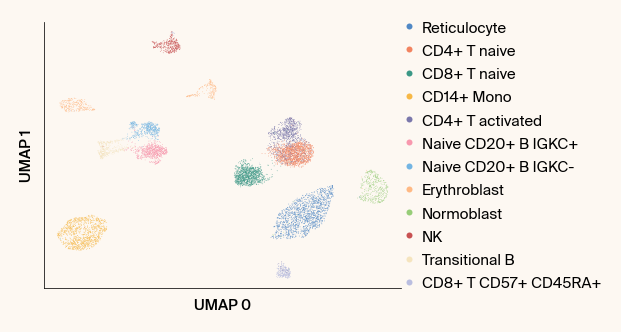

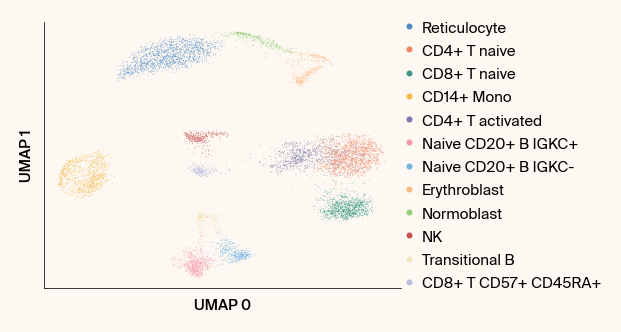

In [ ]:
# | code-fold: true
# | label: fig-umap-original
# | layout-ncol: 2
# | fig-cap: "The conventional ScanPy UMAP and the PyTorch network UMAP. While they are not exactly the same, note the overall similarities. It is also possible to directly fit the embedding learned by the conventional UMAP algorithm, but here we show a fit with the PyTorch method to demonstrate how they find similar embeddings."
# | fig-subcap:
# |   - "The conventional ScanPy UMAP embedding."
# |   - "The PyTorch network UMAP embedding."
adata_final.obsm['X_parametric_umap_0'] = reducer.embeddings_[0]

plot_scanpy_umap(adata_final, groupby=GROUPBY_KEY)

plot_parametric_umap(reducer, adata_final, fit_index=0, groupby=GROUPBY_KEY)

## Exact decomposition of features

The Jacobians are computed for each input over the independent fits. This takes a bit of time: about two minutes per fit on a T4 GPU (on the order of the time spent fitting the model).

In [8]:
# | code-fold: true
# | output: false
if TRAIN:
    adata_mean_zero = adata_final.to_df().values - adata_final.to_df().mean(axis=0).values
    
    reducer.compute_attributions(
        X_centered_gene_expression=adata_mean_zero,
        pca_components=adata_final.varm["PCs"]
    )
    print(SUMMARY_BASENAME)
    reducer.save_analysis_summary(adata_final, groupby=GROUPBY_KEY, basename=SUMMARY_BASENAME)

--- Computing Jacobian for Model 1/1 ---
saved_outputs/bmmc_features_rev


We can validate that the Jacobian reconstructs the embedding network output.

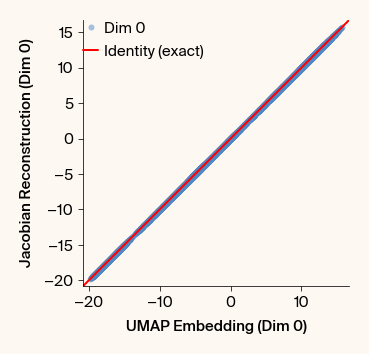

In [9]:
# | code-fold: true
# | label: fig-reconstruction-validation
# | fig-align: center
# | layout-ncol: 1
# | fig-cap: "Exact Jacobian reconstruction. To validate that the Jacobian reconstructs the UMAP encoder network output, we plot the embedding values against their Jacobian reconstructions and see that they fall on the identity line."

validate_jacobian(
    reducer, 
    adata_final, 
    fit_index=0, 
    summary_plot_file=summary_plot_file if not TRAIN else None
)


## PyTorch UMAP with Feature Labels

We can visualize the embedding and add the top gene contributors to the embedding position as information in the hovertip. 
As an alternative visualization, we can color the embedding by the largest gene contributor. In some cases, a given cell type label will have different regions where different genes make the largest contribution, like for Reticulocytes, which have several sub regions where the strongest contributors are HBD and HBA2, but the sub region with HBD as the largest gene contributor also extends to the neighboring Normoblast cluster. The UMAP embedding is placing these points near each other because the HBD activity is similar (and correlations with other features are distinctive).

In [10]:
# | code-fold: true
# | label: fig-umap-hover-top-genes
# | layout-ncol: 1
# | fig-cap: "The PyTorch UMAP embedding colored by cell type with top genes for each cell labeled in the hover tip."
#plotly UMAP embedding with data tags

plot_interactive(
    reducer, 
    adata_final,
    groupby=GROUPBY_KEY,
    color_by='group', # or 'top_gene'
    fit_index=0,
    summary_file=summary_interactive_file if not TRAIN else None
)


### Embedding labeled by top gene contributor

In [11]:
# | code-fold: true
# | label: fig-umap-plot-genes
# | layout-ncol: 1
# | fig-cap: "The PyTorch UMAP embedding colored by top geen feature, showing that some cell types have regions with different top gene contributors, and some top gene contributors extend across type divisons."
#plotly UMAP embedding colored by top gene features

plot_interactive(
    reducer, 
    adata_final,
    groupby=GROUPBY_KEY,
    color_by='top_gene',
    fit_index=0,
    summary_file=summary_interactive_file if not TRAIN else None
)


Bone Marrow: Top Gene Contributors, (83.8% of cells shown)


### Top gene features by cell type

We can also generate these plots on average over each class. With 8 separate UMAP fits at different random initializations, we provide the standard error of the normalized mean contribution of each feature. The feature contributions are normalized by the mean embedding distance of the class for a given fit, since in one fit a class could be class to the origin, and far away from the origin in another. 

Note that the largest feature contributors do not always point in the direction of the centroid. This gives rise to a gradient of contribution across a cluster. 

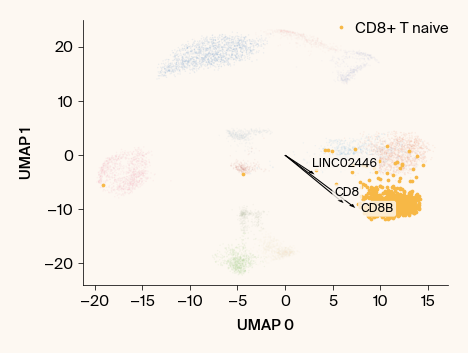

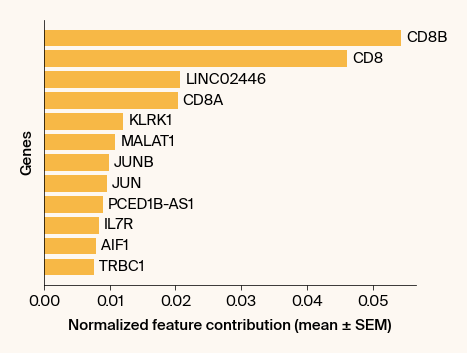

In [65]:
# | code-fold: true
# | label: fig-top-gene-features-by-type-single
# | layout-ncol: 2
# | fig-cap: "The top gene features for each cell type. Note that the largest feature vectors do not always point to the centroid, often indicating a gradient of importance for that feature across the cluster. Error bars are generated by normalizing the feature importance vectors for each cell by the distance to the centroid of the class for that UMAP fit to account for changing cluster centroids across fits."
# | fig-subcap:
# |    - "UMAP feature vectors."
# |    - "UMAP feature lengths."
# Feature Importance by cell type
group_to_plot = adata_final.obs[GROUPBY_KEY].value_counts().index[2:3].tolist()
plot_feature_importance_by_group(
    reducer,
    adata_final,
    groupby=GROUPBY_KEY,
    groups_to_plot=group_to_plot,
    fit_index=0,
    summary_stats_file=summary_stats_file if not TRAIN else None,
    summary_plot_file=summary_plot_file if not TRAIN else None
)

### Dot plots

We can compare the features found by the Jacobian to differential expression.

We find that many of the features found by differential expression between cell types are not preserved in the Jacobian representation. 
This highlights how the Jacobian method provides a complementary view of the feature space to features from differential expression.

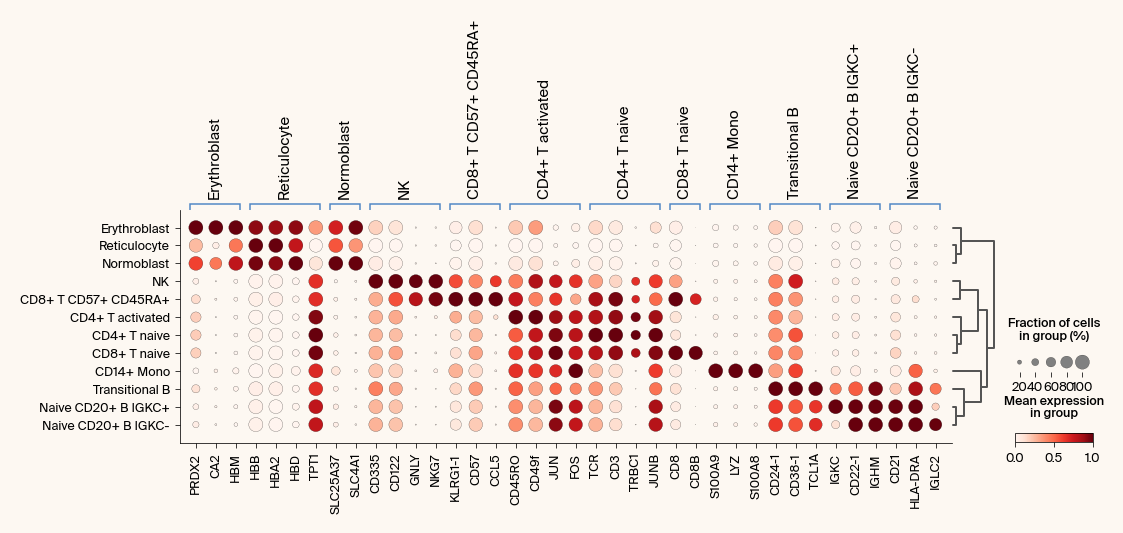

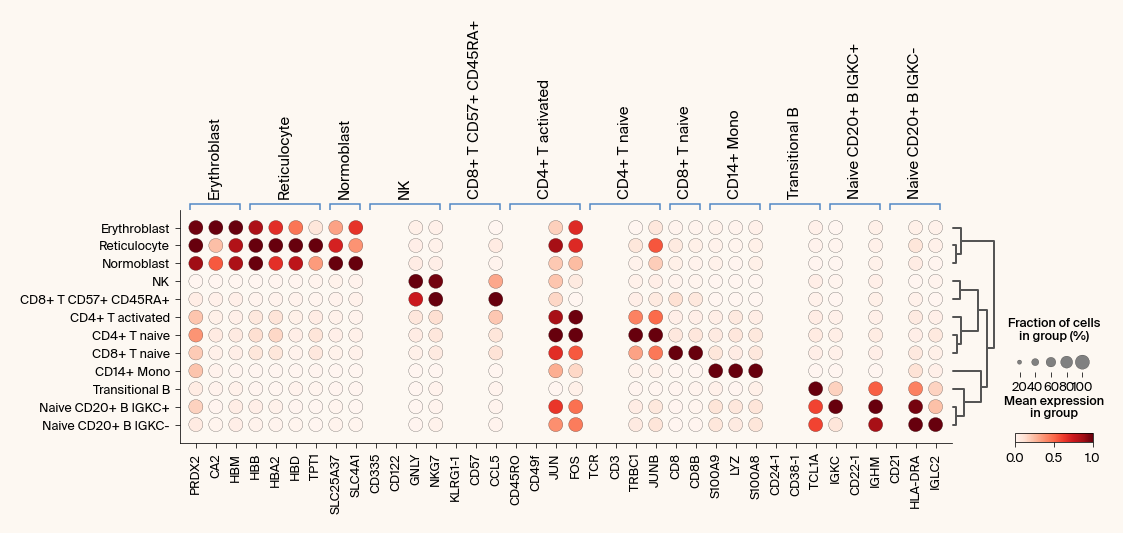

In [ ]:
# | code-fold: true
# | fig-cap: "Dot plots for gene expression analysis."
# | fig-subcap:
# |    - "The dot plot for the top differential expression features by cell type."
# |    - "The dot plot for the top Jacobian features by cell type."
# | label: fig-dotplot
# | layout-ncol: 1
compare_with_differential_expression(
    reducer,
    adata_final,
    groupby=GROUPBY_KEY,
    n_top_genes=2,
    summary_stats_file=summary_stats_file if not TRAIN else None,
    summary_plot_file=summary_plot_file if not TRAIN else None
)


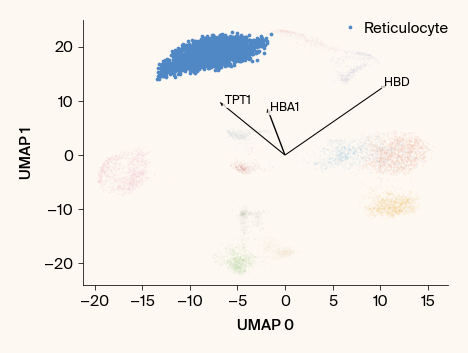

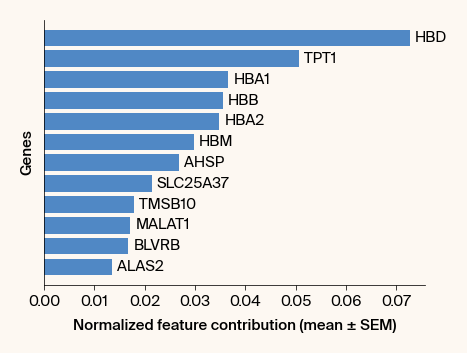

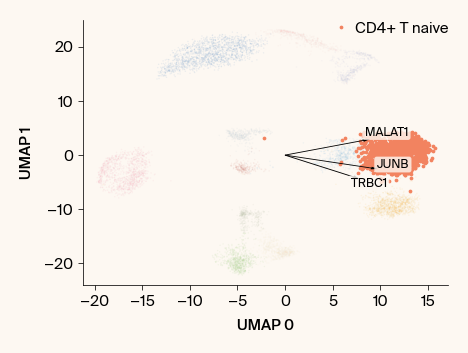

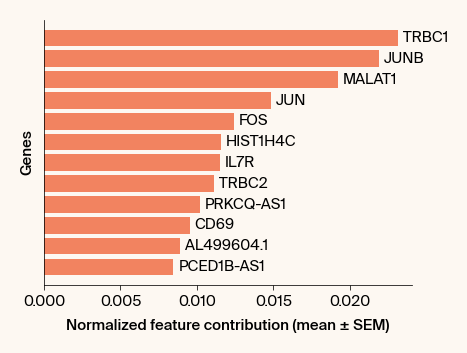

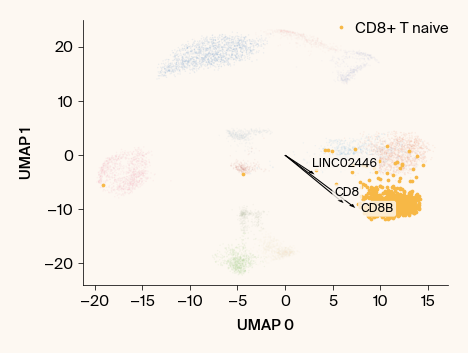

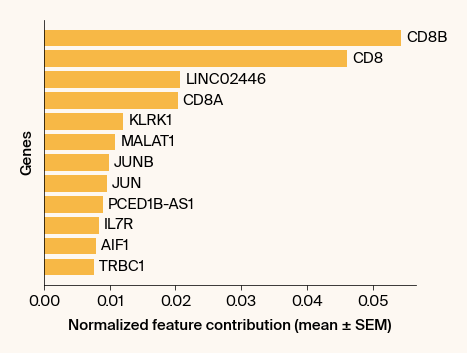

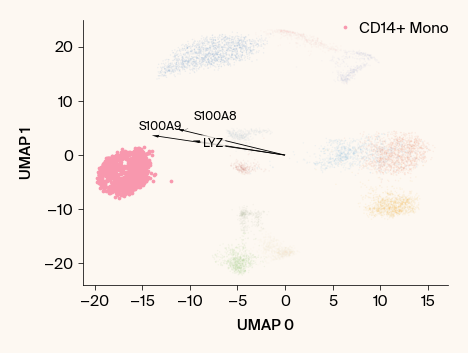

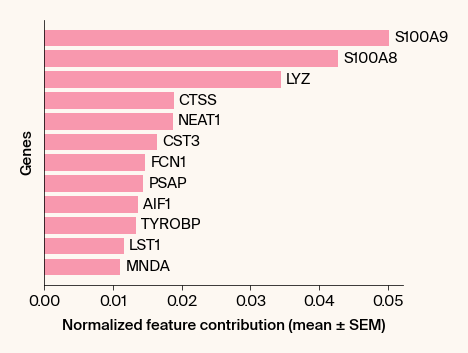

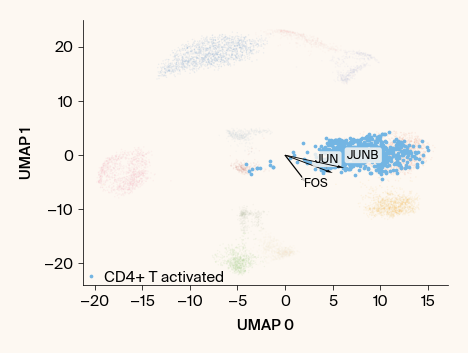

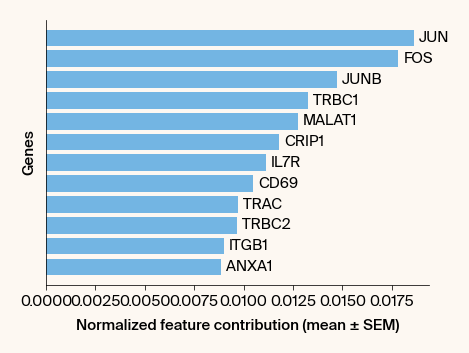

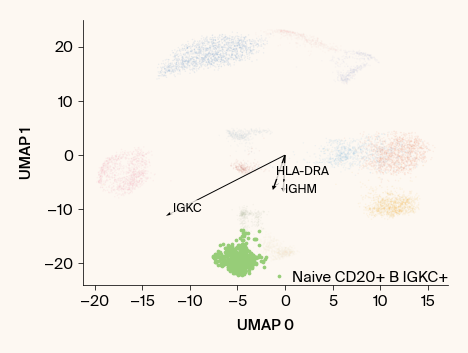

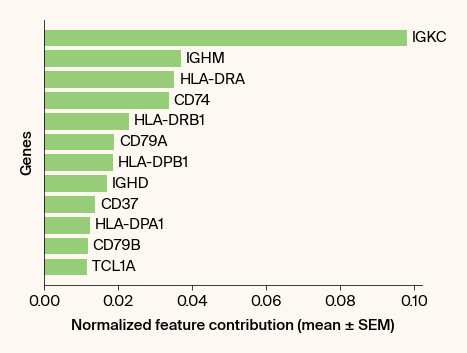

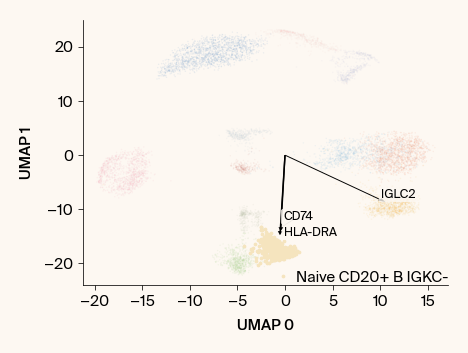

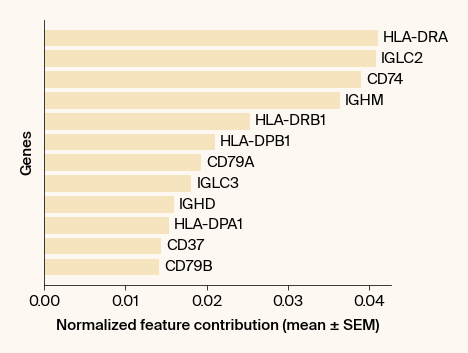

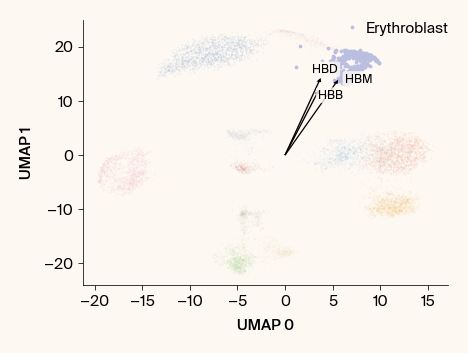

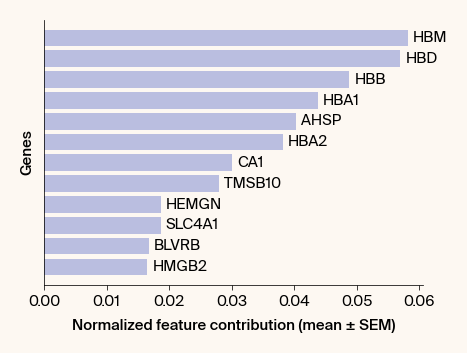

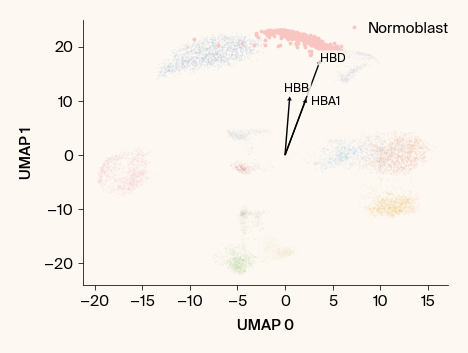

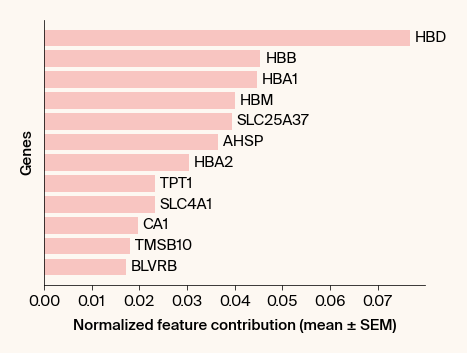

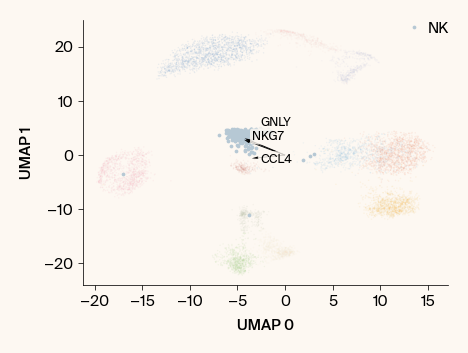

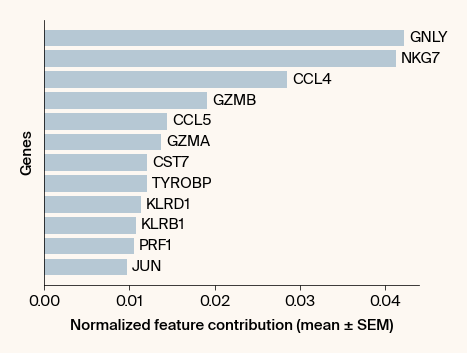

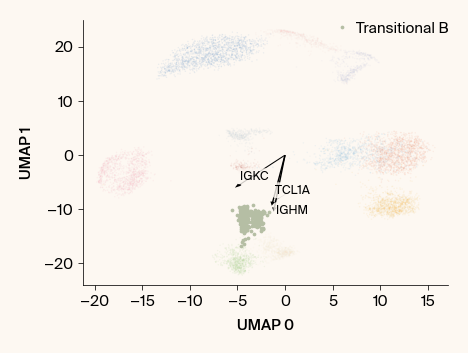

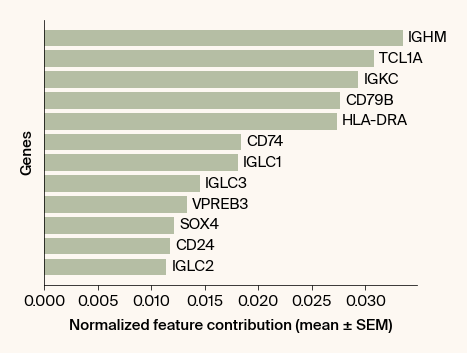

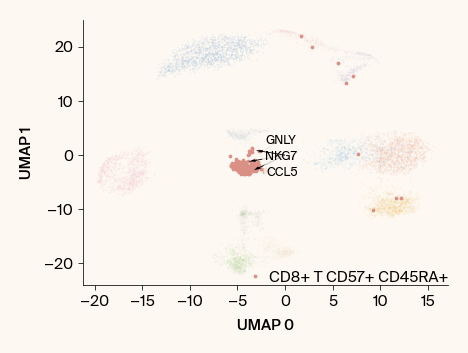

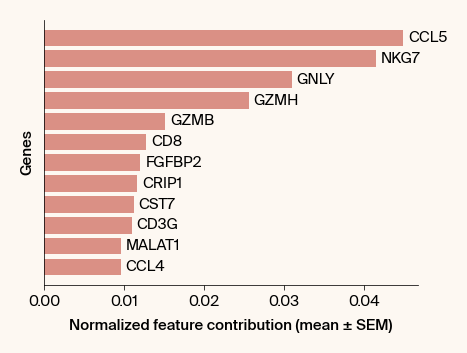

In [66]:
# | label: fig-top-gene-features-by-type-all
# | layout-ncol: 2
# | fig-cap: "The top gene features for each cell type. Note that the largest feature vectors do not always point to the centroid, often indicating a gradient of importance for that feature across the cluster. Error bars are generated by normalizing the feature importance vectors for each cell by the distance to the centroid of the class for that UMAP fit to account for changing cluster centroids across fits."
# | fig-subcap:
# |    - "Cell type: Reticulocyte"
# |    - "Cell type: Reticulocyte"
# |    - "Cell type: CD4+ T naive"
# |    - "Cell type: CD4+ T naive"
# |    - "Cell type: CD8+ T naive"
# |    - "Cell type: CD8+ T naive"
# |    - "Cell type: CD14+ mono"
# |    - "Cell type: CD14+ mono"
# |    - "Cell type: CD4+ T activated"
# |    - "Cell type: CD4+ T activated"
# |    - "Cell type: Naive CD20+ B IGKC+"
# |    - "Cell type: Naive CD20+ B IGKC+"
# |    - "Cell type: Naive CD20+ B IGKC-"
# |    - "Cell type: Naive CD20+ B IGKC-"
# |    - "Cell type: Erythroblast"
# |    - "Cell type: Erythroblast"
# |    - "Cell type: Normoblast"
# |    - "Cell type: Normoblast"
# |    - "Cell type: NK"
# |    - "Cell type: NK"
# |    - "Cell type: Transitional B"
# |    - "Cell type: Transitional B"
# |    - "Cell type: CD8+ T CD57+ CD45RA+"
# |    - "Cell type: CD8+ T CD57+ CD45RA+"
group_to_plot = adata_final.obs[GROUPBY_KEY].value_counts().index[:12].tolist()
plot_feature_importance_by_group(
    reducer,
    adata_final,
    groupby=GROUPBY_KEY,
    groups_to_plot=group_to_plot,
    fit_index=0,
    summary_stats_file=summary_stats_file if not TRAIN else None,
    summary_plot_file=summary_plot_file if not TRAIN else None
)

## Conclusion

This work demonstrates a novel approach to interpreting UMAP embeddings by leveraging glass box deep networks. We've shown how to overcome the traditional black box nature of nonlinear dimensionality reduction, specifically UMAP, by implementing a locally linear (but globally nonlinear) embedding function. This allows for the exact quantification of feature attributions for each data point in the UMAP embedding space, directly quantifying the contribution of individual genes to cell positions for scRNAseq data. This stands in contrast to conventional methods like differential expression, which provide only a proxy for what UMAP has learned.

## References

Chari, T., & Pachter, L. (2023). The specious art of single-cell genomics. PLOS Computational Biology, 19(8), e1011288.

Luecken, M. D., Burkhardt, D. B., Cannoodt, R., Lance, C., Agrawal, A., Aliee, H., ... & Bloom, J. M. (2021, August). A sandbox for prediction and integration of DNA, RNA, and proteins in single cells. In Thirty-fifth conference on neural information processing systems datasets and benchmarks track (Round 2).

Mohan, S., Kadkhodaie, Z., Simoncelli, E. P., & Fernandez-Granda, C. (2019). Robust and interpretable blind image denoising via bias-free convolutional neural networks. arXiv preprint arXiv:1906.05478.

Wang, S., Mohamed, A. R., Caruana, R., Bilmes, J., Plilipose, M., Richardson, M., ... & Aslan, O. (2016, June). Analysis of deep neural networks with extended data jacobian matrix. In International Conference on Machine Learning (pp. 718-726). PMLR.
